In [15]:
"""
Advanced CTMC resilience metrics – two-plot edition (full 10-KPI build)
======================================================================

Outputs
-------
1. plots/advanced_metrics/availability_multiclass.png
2. plots/advanced_metrics/infected_multiclass.png
3. csv/advanced_metrics/advanced_metrics.csv  (10 KPIs per class)
"""

from __future__ import annotations

import random
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import expm_multiply, spsolve

# ── CONFIG ───────────────────────────────────────────────────────────────
BASE_DIR   = Path.cwd()
CTMC_DIR   = BASE_DIR / "csv" / "ctmcs"
OUT_DIR    = BASE_DIR / "csv" / "advanced_metrics"
PLOT_DIR   = BASE_DIR / "plots" / "advanced_metrics"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

TIME_HORIZON = 72                       # h
TIME_GRID    = np.linspace(0, TIME_HORIZON, 37)   # 0,2,…,72
SEED = 2024
random.seed(SEED)

# ── HELPERS ──────────────────────────────────────────────────────────────
def build_Q(df: pd.DataFrame):
    states = sorted(set(df["source"]) | set(df["target"]))
    idx = {s: i for i, s in enumerate(states)}
    rows, cols, data = [], [], []
    for _, r in df.iterrows():
        i, j = idx[r["source"]], idx[r["target"]]
        if i != j:
            rows.append(i)
            cols.append(j)
            data.append(r["rate"])
    n = len(states)
    Q = coo_matrix((data, (rows, cols)), shape=(n, n)).tocsr()
    Q.setdiag(-Q.sum(axis=1).A1)
    return Q, states

def evolve(Q: csr_matrix, alpha: np.ndarray, t: float) -> np.ndarray:
    """Row-vector evolution α·e^{Qt} via expm_multiply on Qᵀ."""
    p = expm_multiply(Q.T * t, alpha)
    p = p.A1 if hasattr(p, "A1") else np.asarray(p).ravel()
    return p / p.sum()

def mean_hitting_time(Qsub: csr_matrix) -> float:
    """Mean time to absorption for a transient sub-generator."""
    if Qsub.shape[0] == 0:
        return float("nan")
    b = np.ones(Qsub.shape[0])
    return float(spsolve(-Qsub, b).mean())

# ── MAIN LOOP ────────────────────────────────────────────────────────────
metrics: List[Dict] = []
curves : Dict[str, Dict[str, np.ndarray]] = {}

for csv_path in CTMC_DIR.glob("ctmc_*.csv"):
    cls = csv_path.stem.replace("ctmc_", "")
    print(f"▶ analysing {cls}")

    df = pd.read_csv(csv_path)
    if df.empty:
        print("   (empty CTMC, skipped)")
        continue

    Q, states = build_Q(df)
    n = len(states)

    # state index groups --------------------------------------------------
    normal_idx      = [i for i,s in enumerate(states) if "normal"      in s.lower()]
    compromised_idx = [i for i,s in enumerate(states) if "compromised" in s.lower()]
    down_idx        = [i for i,s in enumerate(states) if "down"        in s.lower()]
    mitigated_idx   = [i for i,s in enumerate(states) if "mitigated"   in s.lower()]
    recovered_idx   = [i for i,s in enumerate(states) if "recovered"   in s.lower()]

    # initial distribution (all-normal) ----------------------------------
    alpha0 = np.zeros(n)
    alpha0[normal_idx] = 1 / len(normal_idx)

    # weight & cost vectors for SDI / ECL --------------------------------
    weight = np.zeros(n)     # service-degradation index
    cost   = np.zeros(n)     # cyber-loss proxy
    for i, s in enumerate(states):
        if "down" in s.lower():
            weight[i] = 5
            cost[i]   = 10_000
        elif "compromised" in s.lower():
            weight[i] = 1
            cost[i]   = 1_000

    # curves over the time grid ------------------------------------------
    A_curve, I_curve, SDI_curve, ECL_curve = [], [], [], []
    for t in TIME_GRID:
        p = evolve(Q, alpha0, t)
        A_curve.append(p[normal_idx + recovered_idx].sum())
        I_curve.append(p[compromised_idx + down_idx].sum() * len(normal_idx))
        SDI_curve.append(float(p @ weight))
        ECL_curve.append(float(p @ cost))

    A_curve = np.array(A_curve)
    I_curve = np.array(I_curve)

    # scalar KPIs ---------------------------------------------------------
    A_T      = np.trapezoid(A_curve, TIME_GRID) / TIME_HORIZON
    AUC      = np.trapezoid(I_curve, TIME_GRID)                 # node·h
    RTA      = TIME_HORIZON - np.trapezoid(A_curve, TIME_GRID)  # lost-h
    SDI      = np.trapezoid(SDI_curve, TIME_GRID) / TIME_HORIZON
    ECL      = np.trapezoid(ECL_curve, TIME_GRID)               # $

    Q_N      = Q[normal_idx][:, normal_idx]
    MTTC     = mean_hitting_time(Q_N)

    Q_C      = Q[compromised_idx][:, compromised_idx]
    MTTCmp   = mean_hitting_time(Q_C)

    if down_idx and recovered_idx:
        Q_D  = Q[down_idx][:, down_idx]
        MTTR = mean_hitting_time(Q_D)
    else:
        MTTR = float("nan")

    # mitigation-success ratio -------------------------------------------
    if compromised_idx and mitigated_idx and down_idx:
        b_vec = -Q[np.ix_(compromised_idx, mitigated_idx)].sum(axis=1)
        MSR   = float(spsolve(Q_C, b_vec).mean())
    else:
        MSR = float("nan")

    p10   = evolve(Q, alpha0, 10)
    R_eff = (p10[compromised_idx].sum() * len(normal_idx)) / len(normal_idx)

    # save per-class metrics ---------------------------------------------
    metrics.append({
        "Class":           cls,
        "A(0,72h)":        A_T,
        "MTTC(h)":         MTTC,
        "MTTR(h)":         MTTR,
        "R_effective":     R_eff,
        "AUC(nodes·h)":    AUC,
        "RTA(h)":          RTA,
        "MTTCmp(h)":       MTTCmp,
        "MSR":             MSR,
        "SDI(weight)":     SDI,
        "ECL($)":          ECL,
    })
    curves[cls] = {"A": A_curve, "I": I_curve}

# ── MULTI-CLASS PLOTS ───────────────────────────────────────────────────
plt.figure(figsize=(9,5))
for cls, d in curves.items():
    plt.plot(TIME_GRID, d["A"], label=cls)
plt.xlabel("Time (h)")
plt.ylabel("Availability")
plt.title("Availability curves – all classes")
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_DIR / "availability_multiclass.png")
plt.close()

plt.figure(figsize=(9,5))
for cls, d in curves.items():
    plt.plot(TIME_GRID, d["I"], label=cls)
plt.xlabel("Time (h)")
plt.ylabel("Expected # infected/down nodes")
plt.title("Infected curves – all classes")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(PLOT_DIR / "infected_multiclass.png")
plt.close()

# ── WRITE CSV ────────────────────────────────────────────────────────────
pd.DataFrame(metrics).to_csv(OUT_DIR / "advanced_metrics.csv", index=False)
print("Two plots saved to", PLOT_DIR)
print("Metrics table (10 KPIs) saved to", OUT_DIR)


▶ analysing ambulance_station
▶ analysing atm
▶ analysing bank
▶ analysing gov_office
▶ analysing hospital
▶ analysing power
▶ analysing surveillance
▶ analysing telecom
Two plots saved to E:\Dropbox\Personale\Ricerca\XAI\00. A.Gatti\urban_ctmc\plots\advanced_metrics
Metrics table (10 KPIs) saved to E:\Dropbox\Personale\Ricerca\XAI\00. A.Gatti\urban_ctmc\csv\advanced_metrics


# Extra metrics

In [16]:
# ───────────────────────── Stakeholder-specific dashboards ───────────────
df = pd.read_csv(OUT_DIR / "advanced_metrics.csv").set_index("Class")

# helper: generic grouped-bar plot ----------------------------------------
def grouped_bar(ax, df_subset, title, colors=None):
    colors = colors or plt.cm.tab10.colors
    x = np.arange(len(df_subset))             # class positions
    width = 0.8 / len(df_subset.columns)      # bar width
    for i, col in enumerate(df_subset.columns):
        ax.bar(x + i * width, df_subset[col], width,
               label=col, color=colors[i % len(colors)])
    ax.set_xticks(x + width * (len(df_subset.columns) - 1) / 2)
    ax.set_xticklabels(df_subset.index, rotation=45, ha="right")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()

# 1) Operational team: MTTCmp, MTTR, AUC ----------------------------------
ops_cols = [c for c in ("MTTCmp(h)", "MTTR(h)", "AUC(nodes·h)") if c in df.columns]
fig, ax = plt.subplots(figsize=(8, 5))
grouped_bar(ax, df[ops_cols], "Operational metrics")
fig.tight_layout()
fig.savefig(PLOT_DIR / "ops_metrics.png")
plt.close(fig)

# 2) Risk officers: P(CF), ECL, CVaR --------------------------------------
risk_cols = [c for c in ("P(CF)", "ECL($)", "CVaR($)") if c in df.columns]
if risk_cols:
    fig, ax = plt.subplots(figsize=(8, 5))
    grouped_bar(ax, df[risk_cols], "Risk-focused metrics")
    fig.tight_layout()
    fig.savefig(PLOT_DIR / "risk_metrics.png")
    plt.close(fig)

# 3) Budget / engineering: ΔA/Δλ -----------------------------------------
budget_cols = [c for c in ("ΔA/Δλ",) if c in df.columns]
if budget_cols:
    fig, ax = plt.subplots(figsize=(7, 4))
    grouped_bar(ax, df[budget_cols], "Budget efficiency (availability gain per rate change)",
                colors=["purple"])
    fig.tight_layout()
    fig.savefig(PLOT_DIR / "budget_metrics.png")
    plt.close(fig)

print(" Stakeholder-specific plots added in", PLOT_DIR)


 Stakeholder-specific plots added in E:\Dropbox\Personale\Ricerca\XAI\00. A.Gatti\urban_ctmc\plots\advanced_metrics


In [17]:
"""
Advanced CTMC resilience metrics – two-plot core + stakeholder dashboards
=========================================================================
Outputs
-------
plots/advanced_metrics/
    availability_multiclass.png      – availability vs. t, every class
    infected_multiclass.png          – infected vs. t, every class
    operational_metrics.png          – 3-panel bar charts  (MTTCmp, MTTR, AUC)
    risk_metrics.png                 – grouped bars        (ECL, P(CF), CVaR*)
    budget_efficiency.png            – grouped bars        (ΔA/Δλ*)

csv/advanced_metrics/advanced_metrics.csv
    full 10-KPI table per class
(* plotted only if the column exists in the table)
"""

from __future__ import annotations
import random
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import expm_multiply, spsolve

# ── CONFIG ───────────────────────────────────────────────────────────────
BASE_DIR   = Path.cwd()
CTMC_DIR   = BASE_DIR / "csv" / "ctmcs"
OUT_DIR    = BASE_DIR / "csv" / "advanced_metrics"
PLOT_DIR   = BASE_DIR / "plots" / "advanced_metrics"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

TIME_HORIZON = 72                 # hours
TIME_GRID    = np.linspace(0, TIME_HORIZON, 37)  # 0-72 by 2 h
SEED = 2024
random.seed(SEED)

# ── HELPERS ──────────────────────────────────────────────────────────────
def build_Q(df: pd.DataFrame):
    states = sorted(set(df["source"]) | set(df["target"]))
    idx    = {s: i for i, s in enumerate(states)}
    rows, cols, data = [], [], []
    for _, r in df.iterrows():
        i, j = idx[r["source"]], idx[r["target"]]
        if i != j:
            rows.append(i); cols.append(j); data.append(r["rate"])
    n = len(states)
    Q = coo_matrix((data, (rows, cols)), shape=(n, n)).tocsr()
    Q.setdiag(-Q.sum(axis=1).A1)
    return Q, states

def evolve(Q: csr_matrix, alpha: np.ndarray, t: float) -> np.ndarray:
    p = expm_multiply(Q.T * t, alpha)
    p = p.A1 if hasattr(p, "A1") else np.asarray(p).ravel()
    return p / p.sum()

def mean_hitting_time(Qsub: csr_matrix) -> float:
    if Qsub.shape[0] == 0:
        return float("nan")
    b = np.ones(Qsub.shape[0])
    return float(spsolve(-Qsub, b).mean())

# ── MAIN LOOP ────────────────────────────────────────────────────────────
metrics: List[Dict] = []
curves : Dict[str, Dict[str, np.ndarray]] = {}

for csv_path in CTMC_DIR.glob("ctmc_*.csv"):
    cls = csv_path.stem.replace("ctmc_", "")
    print(f"▶ analysing {cls}")

    df = pd.read_csv(csv_path)
    if df.empty:
        print("   (empty CTMC, skipped)")
        continue

    Q, states = build_Q(df)
    n = len(states)

    normal_idx      = [i for i,s in enumerate(states) if "normal"      in s.lower()]
    compromised_idx = [i for i,s in enumerate(states) if "compromised" in s.lower()]
    down_idx        = [i for i,s in enumerate(states) if "down"        in s.lower()]
    mitigated_idx   = [i for i,s in enumerate(states) if "mitigated"   in s.lower()]
    recovered_idx   = [i for i,s in enumerate(states) if "recovered"   in s.lower()]

    alpha0 = np.zeros(n);  alpha0[normal_idx] = 1 / len(normal_idx)

    weight = np.zeros(n);  cost = np.zeros(n)
    for i, s in enumerate(states):
        if "down" in s.lower():            weight[i], cost[i] = 5, 10_000
        elif "compromised" in s.lower():   weight[i], cost[i] = 1,  1_000

    A_curve, I_curve, SDI_curve, ECL_curve = [], [], [], []
    for t in TIME_GRID:
        p = evolve(Q, alpha0, t)
        A_curve.append(p[normal_idx + recovered_idx].sum())
        I_curve.append(p[compromised_idx + down_idx].sum() * len(normal_idx))
        SDI_curve.append(float(p @ weight))
        ECL_curve.append(float(p @ cost))

    A_curve, I_curve = np.array(A_curve), np.array(I_curve)

    # scalar KPIs ---------------------------------------------------------
    A_T    = np.trapezoid(A_curve, TIME_GRID) / TIME_HORIZON
    AUC    = np.trapezoid(I_curve, TIME_GRID)                 # node·h
    RTA    = TIME_HORIZON - np.trapezoid(A_curve, TIME_GRID)  # lost-h
    SDI    = np.trapezoid(SDI_curve, TIME_GRID) / TIME_HORIZON
    ECL    = np.trapezoid(ECL_curve, TIME_GRID)               # $

    MTTC   = mean_hitting_time(Q[normal_idx][:, normal_idx])
    MTTCmp = mean_hitting_time(Q[compromised_idx][:, compromised_idx])
    MTTR   = (mean_hitting_time(Q[down_idx][:, down_idx])
              if down_idx and recovered_idx else float("nan"))

    # mitigation-success ratio -------------------------------------------
    if compromised_idx and mitigated_idx and down_idx:
        b_vec = -Q[np.ix_(compromised_idx, mitigated_idx)].sum(axis=1)
        MSR   = float(spsolve(Q[compromised_idx][:, compromised_idx], b_vec).mean())
    else:
        MSR = float("nan")

    R_eff = (evolve(Q, alpha0, 10)[compromised_idx].sum() * len(normal_idx)
             / len(normal_idx))

    metrics.append({
        "Class":           cls,
        "A(0,72h)":        A_T,
        "MTTC(h)":         MTTC,
        "MTTR(h)":         MTTR,
        "R_effective":     R_eff,
        "AUC(nodes·h)":    AUC,
        "RTA(h)":          RTA,
        "MTTCmp(h)":       MTTCmp,
        "MSR":             MSR,
        "SDI(weight)":     SDI,
        "ECL($)":          ECL,
    })
    curves[cls] = {"A": A_curve, "I": I_curve}

# ── MULTI-CLASS TIME-SERIES PLOTS ────────────────────────────────────────
plt.figure(figsize=(9,5))
for cls, d in curves.items():
    plt.plot(TIME_GRID, d["A"], label=cls)
plt.xlabel("Time (h)"); plt.ylabel("Availability")
plt.title("Availability curves – all classes")
plt.ylim(0,1); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(PLOT_DIR / "availability_multiclass.png"); plt.close()

plt.figure(figsize=(9,5))
for cls, d in curves.items():
    plt.plot(TIME_GRID, d["I"], label=cls)
plt.xlabel("Time (h)"); plt.ylabel("Expected # infected/down nodes")
plt.title("Infected curves – all classes")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(PLOT_DIR / "infected_multiclass.png"); plt.close()

# ── WRITE METRICS CSV ────────────────────────────────────────────────────
pd.DataFrame(metrics).to_csv(OUT_DIR / "advanced_metrics.csv", index=False)
print("Two plots saved to", PLOT_DIR)
print("Metrics table saved to", OUT_DIR)

# ── STAKEHOLDER DASHBOARDS ───────────────────────────────────────────────
df = pd.read_csv(OUT_DIR / "advanced_metrics.csv").set_index("Class")

def save_subplots(filename: str, columns: list[str], title: str):
    cols = [c for c in columns if c in df.columns]
    if not cols:
        print(f"(skip {filename} – no data)"); return
    n = len(cols)
    fig, axes = plt.subplots(1, n, figsize=(4.5*n,5), sharey=False)
    axes = axes if isinstance(axes, np.ndarray) else np.array([axes])
    x = np.arange(len(df))
    for ax, col in zip(axes, cols):
        ax.bar(x, df[col], color="tab:blue")
        ax.set_xticks(x); ax.set_xticklabels(df.index, rotation=45, ha="right")
        ax.set_title(col); ax.grid(True, axis="y", alpha=0.3)
    fig.suptitle(title); fig.tight_layout(rect=[0,0.03,1,0.93])
    fig.savefig(PLOT_DIR / filename); plt.close(fig)

def save_grouped(filename: str, columns: list[str], title: str, color="tab:blue"):
    cols = [c for c in columns if c in df.columns]
    if not cols:
        print(f"(skip {filename} – no data)"); return
    x = np.arange(len(df)); width = 0.8/len(cols)
    plt.figure(figsize=(8,5))
    for i, col in enumerate(cols):
        plt.bar(x + i*width, df[col], width, label=col, color=color if len(cols)==1 else None)
    plt.xticks(x + width*(len(cols)-1)/2, df.index, rotation=45, ha="right")
    plt.title(title); plt.grid(True, axis="y", alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(PLOT_DIR / filename); plt.close()

# operational: subplots
save_subplots("operational_metrics.png",
              ["MTTCmp(h)", "MTTR(h)", "AUC(nodes·h)"],
              "Operational metrics")

# risk: grouped bars
save_grouped("risk_metrics.png",
             ["P(CF)", "ECL($)", "CVaR($)"],
             "Risk-focused metrics")

# budget: grouped bars
save_grouped("budget_efficiency.png",
             ["ΔA/Δλ"], "Budget efficiency – ΔA / Δλ", color="purple")

print("Stakeholder plots saved to", PLOT_DIR)


▶ analysing ambulance_station
▶ analysing atm
▶ analysing bank
▶ analysing gov_office
▶ analysing hospital
▶ analysing power
▶ analysing surveillance
▶ analysing telecom
Two plots saved to E:\Dropbox\Personale\Ricerca\XAI\00. A.Gatti\urban_ctmc\plots\advanced_metrics
Metrics table saved to E:\Dropbox\Personale\Ricerca\XAI\00. A.Gatti\urban_ctmc\csv\advanced_metrics
(skip budget_efficiency.png – no data)
Stakeholder plots saved to E:\Dropbox\Personale\Ricerca\XAI\00. A.Gatti\urban_ctmc\plots\advanced_metrics


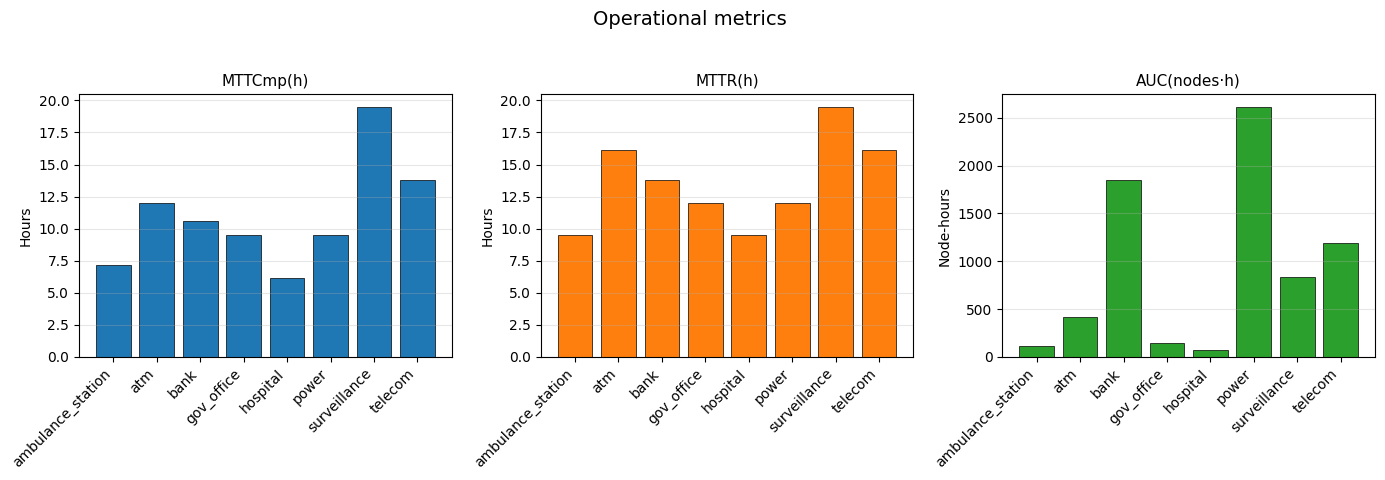

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ----------------------------------------------------------------------
# Load the KPI table produced earlier
# ----------------------------------------------------------------------
df = pd.read_csv(Path("csv/advanced_metrics/advanced_metrics.csv")).set_index("Class")

# Optional: put classes in a fixed order
order = ["ambulance_station", "atm", "bank", "gov_office",
         "hospital", "power", "surveillance", "telecom"]
df = df.loc[order]

# Three operational indicators
kpis = {
    "MTTCmp(h)":      {"color": "tab:blue",   "ylabel": "Hours"},
    "MTTR(h)":        {"color": "tab:orange", "ylabel": "Hours"},
    "AUC(nodes·h)":   {"color": "tab:green",  "ylabel": "Node-hours"},
}

# ----------------------------------------------------------------------
# Plot each KPI in its own subplot so scales are independent
# ----------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True)

x = np.arange(len(df))       # class positions
bar_width = 0.8              # full-width bars

for ax, (metric, meta) in zip(axes, kpis.items()):
    ax.bar(
        x,
        df[metric],
        width=bar_width,
        color=meta["color"],
        edgecolor="k",
        linewidth=0.5,
    )
    ax.set_title(metric, fontsize=11)
    ax.set_ylabel(meta["ylabel"])
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=45, ha="right")
    ax.grid(True, axis="y", alpha=0.3)

fig.suptitle("Operational metrics", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(Path("plots/advanced_metrics/operational_metrics_split.png"))
plt.show()
